# **Fine-Tuning**
- With PyTorch (Without Lightning)
- Fine-tuning the whole pre-trained network
- Fine-tuning a certail number of layers.

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Download and unzip the Hymenoptera dataset (Ants & Bees)

!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip


In [ ]:
# Data augmentation and normalization

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),

        # Subtracts the mean from each value and then divides by the standard deviation.
        # We pre-process the model according to the pre-trained model (Fact).
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        # resizes the images so the shortest side has a length of 256 pixels.
        # The other side is scaled to maintain the aspect ratio of the image.
        # These steps are required for ImageNet pretrained model.
        transforms.Resize(256),

        # crops the center of the image so it is a 224 by 224 pixels square image.
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [ ]:
# Set to your image path
data_dir = './hymenoptera_data'

# Use ImageFolder to point to our full dataset
image_datasets = {}
for x in ['train', 'val']:
    dataset = datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    image_datasets[x] = dataset

# Create our dataloaders
dataloaders = {}
for x in ['train', 'val']:
  dataloaders[x] = torch.utils.data.DataLoader(image_datasets[x],
                              batch_size = 4,
                              shuffle = True,
                              num_workers = 4
                              )

# Ger out dataset sizes
dataset_sizes = {}
for x in ['train', 'val']:
  dataset_sizes[x] = len(image_datasets[x])

class_names = image_datasets['train'].classes
print(class_names)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


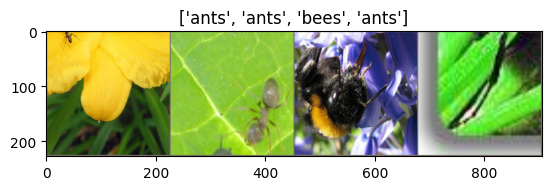

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
# Preparing the training loop

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Find the best model and deep copy it
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Visualizing the predictions

def visualize_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [ ]:
# Setting up the model and start training (Fine-tuning the whole network)

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Fit the model
model_ft = train_model(model_ft,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 47.1MB/s]


Epoch 0/4
----------
train Loss: 0.9210 Acc: 0.6475
val Loss: 0.4612 Acc: 0.8366

Epoch 1/4
----------
train Loss: 0.5001 Acc: 0.8074
val Loss: 0.3470 Acc: 0.8693

Epoch 2/4
----------
train Loss: 0.4548 Acc: 0.8074
val Loss: 0.2743 Acc: 0.8954

Epoch 3/4
----------
train Loss: 0.4118 Acc: 0.8320
val Loss: 0.2709 Acc: 0.8758

Epoch 4/4
----------
train Loss: 0.6532 Acc: 0.7664
val Loss: 0.2842 Acc: 0.8889

Training complete in 0m 28s
Best val Acc: 0.895425


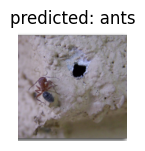

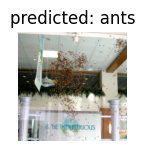

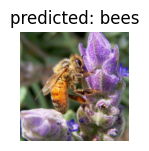

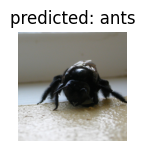

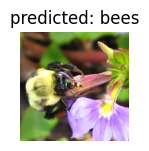

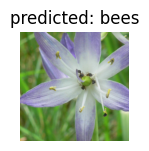

In [ ]:
# Visualizing the predictions

visualize_predictions(model_ft)

In [ ]:
# Setting up the model and start training (Fine-tuning the last layer of the network)

model_conv = torchvision.models.resnet18(pretrained=True)

# We freeze layers here
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [ ]:
model_conv = train_model(model_conv,
                         criterion,
                         optimizer_conv,
                         exp_lr_scheduler,
                         num_epochs=5)


Epoch 0/4
----------
train Loss: 0.6158 Acc: 0.6598
val Loss: 0.2479 Acc: 0.9216

Epoch 1/4
----------
train Loss: 0.4245 Acc: 0.7951
val Loss: 0.1875 Acc: 0.9412

Epoch 2/4
----------
train Loss: 0.4539 Acc: 0.8279
val Loss: 0.1555 Acc: 0.9542

Epoch 3/4
----------
train Loss: 0.4332 Acc: 0.7951
val Loss: 0.3001 Acc: 0.8889

Epoch 4/4
----------
train Loss: 0.4650 Acc: 0.8115
val Loss: 0.1673 Acc: 0.9477

Training complete in 0m 17s
Best val Acc: 0.954248


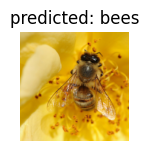

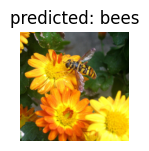

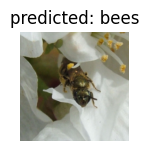

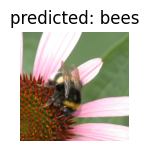

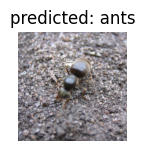

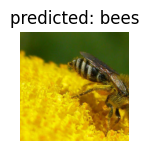

In [ ]:
visualize_predictions(model_conv)
